In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Text processing
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Statistical analysis
from scipy.stats import mannwhitneyu

# Plot style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. 📥 Data Loading and Initial Inspection


In [ ]:
print("📂 Loading datasets...")
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
df_holdout = pd.read_csv('dataset/holdout.csv', delimiter=';')  # Note: semicolon delimiter

print(f"✅ Training set: {df_train.shape[0]:,} samples")
print(f"✅ Test set: {df_test.shape[0]:,} samples")
print(f"✅ Holdout set: {df_holdout.shape[0]:,} samples")
print(f"✅ Total samples: {df_train.shape[0] + df_test.shape[0] + df_holdout.shape[0]:,}")

print("\n" + "="*50)
print("📊 DATASET OVERVIEW")
print("="*50)


In [ ]:
print("📋 DATASET INFORMATION")
print("=" * 30)
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"Holdout set shape: {df_holdout.shape}")

print("\n📊 COLUMN INFORMATION")
print("=" * 30)
print("Training set:")
print(df_train.info())

print("\n🔍 DATA TYPES & MISSING VALUES")
print("=" * 30)
print("Training set:")
print(f"Missing values: {df_train.isnull().sum().sum()}")
print(f"Data types:\n{df_train.dtypes}")

print("\nTest set:")
print(f"Missing values: {df_test.isnull().sum().sum()}")

print("\nHoldout set:")
print(f"Missing values: {df_holdout.isnull().sum().sum()}")


## 2. 📊 Label Distribution Analysis


In [ ]:
# Build label distribution figures and stats across datasets
import pandas as pd

datasets = [
    (df_train, 'Training Set'),
    (df_test, 'Test Set'), 
    (df_holdout, 'Holdout Set')
]

all_datasets_stats = []
for df, name in datasets:
    label_counts = df['label'].value_counts().sort_index()
    total = len(df)
    normal_count = label_counts.get(0, 0)
    gambling_count = label_counts.get(1, 0)
    gambling_ratio = (gambling_count / total * 100) if total else 0
    all_datasets_stats.append({
        'Dataset': name,
        'Total': total,
        'Normal (0)': normal_count,
        'Gambling (1)': gambling_count,
        'Gambling %': gambling_ratio,
        'Class Ratio (0:1)': f"{normal_count}:{gambling_count}"
    })

stats_df = pd.DataFrame(all_datasets_stats)
print("\n📈 DETAILED LABEL DISTRIBUTION STATISTICS")
print("=" * 60)
print(stats_df.to_string(index=False))


In [ ]:
print("🔄 COMBINED DATASET ANALYSIS")
print("=" * 40)

df_combined = pd.concat([
    df_train.assign(dataset='train'),
    df_test.assign(dataset='test'),
    df_holdout.assign(dataset='holdout')
], ignore_index=True)

print(f"Total combined samples: {len(df_combined):,}")
print(f"Overall label distribution:")
overall_dist = df_combined['label'].value_counts().sort_index()
for label, count in overall_dist.items():
    label_name = 'Normal' if label == 0 else 'Gambling'
    percentage = count / len(df_combined) * 100
    print(f"  {label_name} ({label}): {count:,} ({percentage:.2f}%)")

imbalance_ratio = overall_dist[0] / overall_dist[1]
print(f"\n⚖️ Class imbalance ratio (Normal:Gambling): {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️  ALERT: Significant class imbalance detected!")
    print("   Consider using techniques like:")
    print("   - SMOTE (Synthetic Minority Oversampling)")
    print("   - Class weights in models")
    print("   - Stratified sampling")
elif imbalance_ratio > 1.5:
    print("⚠️  MODERATE: Moderate class imbalance detected")
    print("   Monitor model performance on minority class")
else:
    print("✅ BALANCED: Classes are relatively balanced")


## 3. 📏 Text Length Analysis


In [ ]:
print("📏 TEXT LENGTH ANALYSIS")
print("=" * 30)

df_combined['comment_length'] = df_combined['comment'].str.len()
df_combined['word_count'] = df_combined['comment'].str.split().str.len()

print("📊 TEXT LENGTH STATISTICS BY LABEL")
print("=" * 40)

length_stats = df_combined.groupby('label')['comment_length'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

word_stats = df_combined.groupby('label')['word_count'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("Character Length Statistics:")
print(length_stats)
print("\nWord Count Statistics:")
print(word_stats)


📂 Loading datasets...
✅ Training set: 8,171 samples
✅ Test set: 2,335 samples
✅ Holdout set: 1,167 samples
✅ Total samples: 11,673

📊 DATASET OVERVIEW


,comment,label
27,𝐃 𝐎 𝙍 𝘈 𝟽 7 emang gachor parah,1
33,main d 𝐸 𝐖 𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan...,1
43,225 langsung 𝐒𝐆𝐈𝟖𝟖 bang 😹😹,1
58,mencari platform mendorong pertumbuhan 𝘿 𝐄 w a...,1
71,makasih 𝐊𝗨𝗦𝗨𝗠𝗔𝗧𝟎𝗧𝟎uda ngasih 🔍 ✅,1


📋 DATASET INFORMATION
Training set shape: (8171, 2)
Test set shape: (2335, 2)
Holdout set shape: (1167, 2)

📊 COLUMN INFORMATION
Training set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8171 entries, 0 to 8170
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  8171 non-null   object
 1   label    8171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 127.8+ KB
None

🔍 DATA TYPES & MISSING VALUES
Training set:
Missing values: 0
Data types:
comment    object
label       int64
dtype: object

Test set:
Missing values: 0

Holdout set:
Missing values: 0


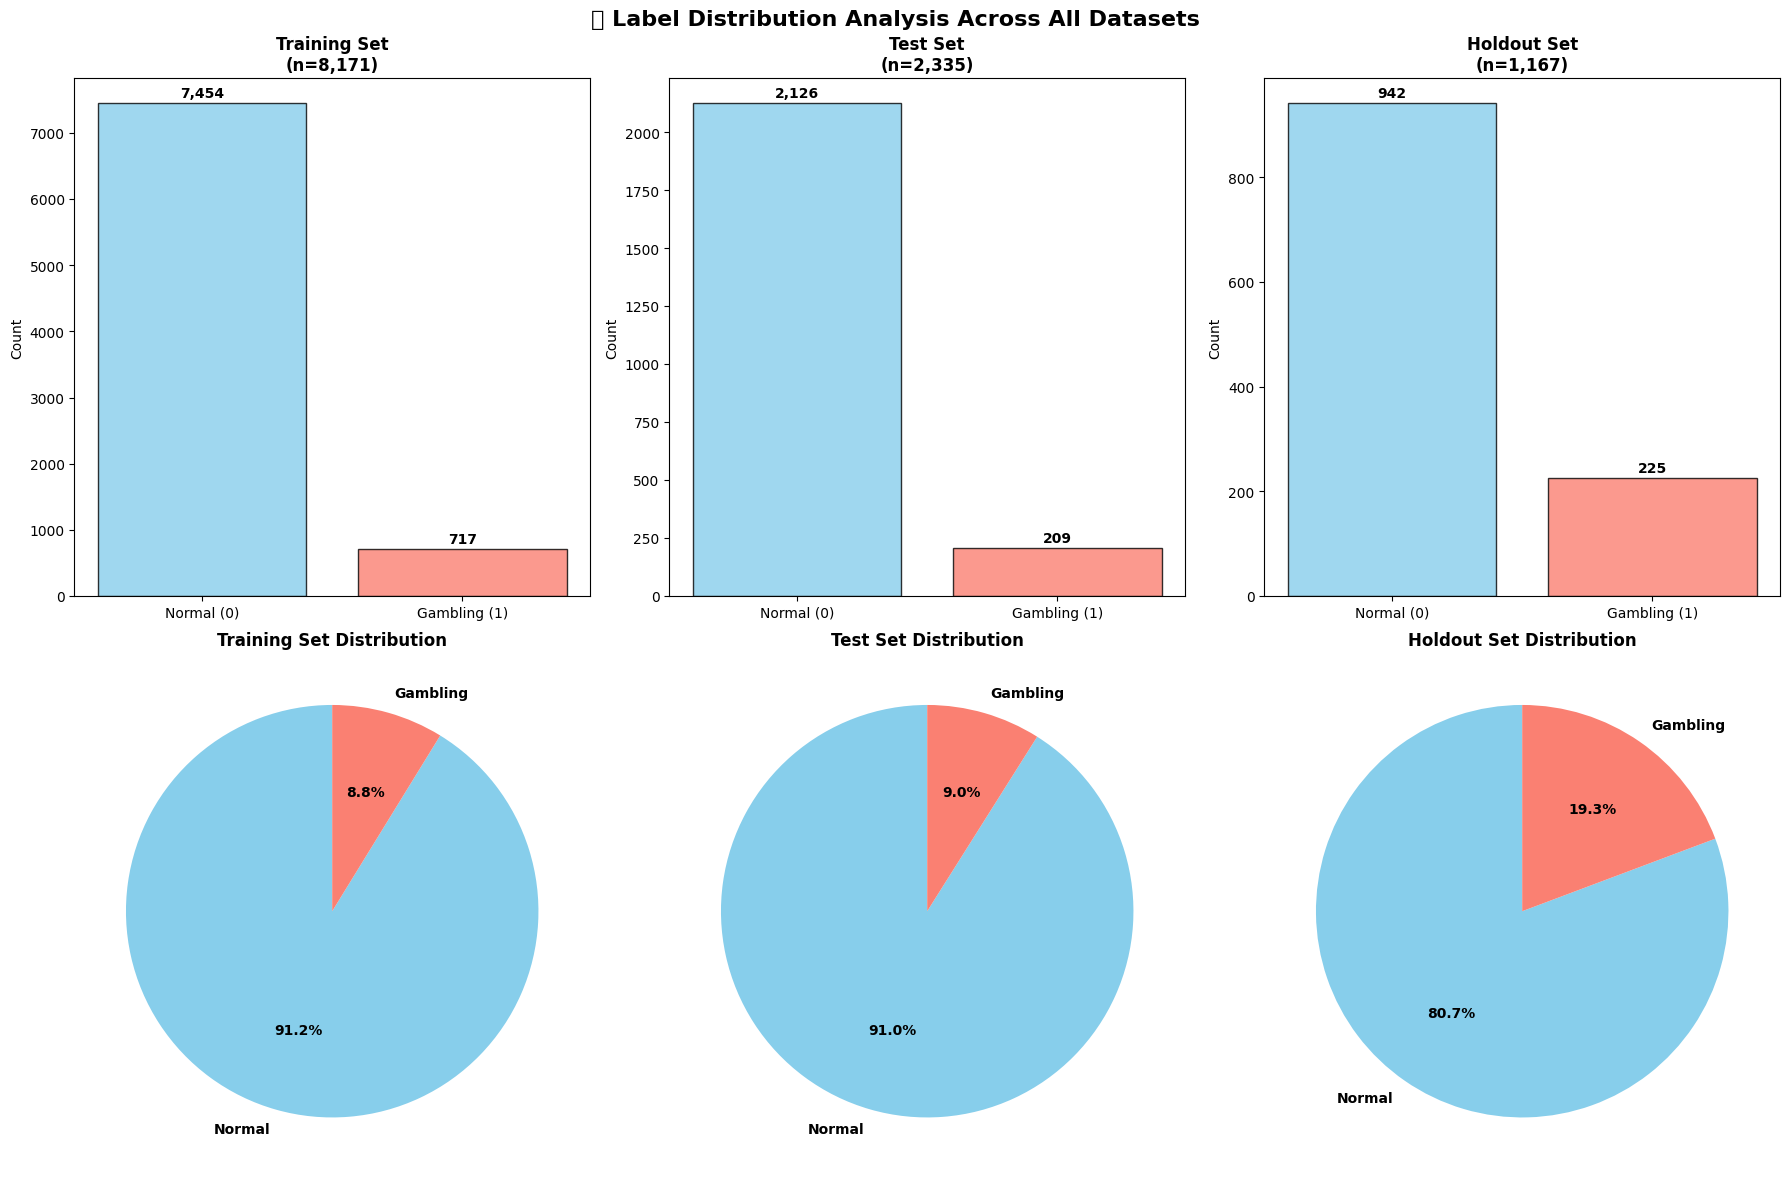


📈 DETAILED LABEL DISTRIBUTION STATISTICS
     Dataset  Total  Normal (0)  Gambling (1)  Gambling % Class Ratio (0:1)
Training Set   8171        7454           717    8.774936          7454:717
    Test Set   2335        2126           209    8.950749          2126:209
 Holdout Set   1167         942           225   19.280206           942:225


🔄 COMBINED DATASET ANALYSIS
Total combined samples: 11,673
Overall label distribution:
  Normal (0): 10,522 (90.14%)
  Gambling (1): 1,151 (9.86%)

⚖️ Class imbalance ratio (Normal:Gambling): 9.14:1
⚠️  ALERT: Significant class imbalance detected!
   Consider using techniques like:
   - SMOTE (Synthetic Minority Oversampling)
   - Class weights in models
   - Stratified sampling


📏 TEXT LENGTH ANALYSIS
📊 TEXT LENGTH STATISTICS BY LABEL
Character Length Statistics:
       count   mean  median     std  min   max
label                                         
0      10522  65.87    33.0  128.29    1  5258
1       1151  44.76    44.0   16.10    3   245

Word Count Statistics:
       count   mean  median   std  min  max
label                                      
0      10522  10.54     6.0  19.6    1  851
1       1151   9.21     9.0   3.9    1   35


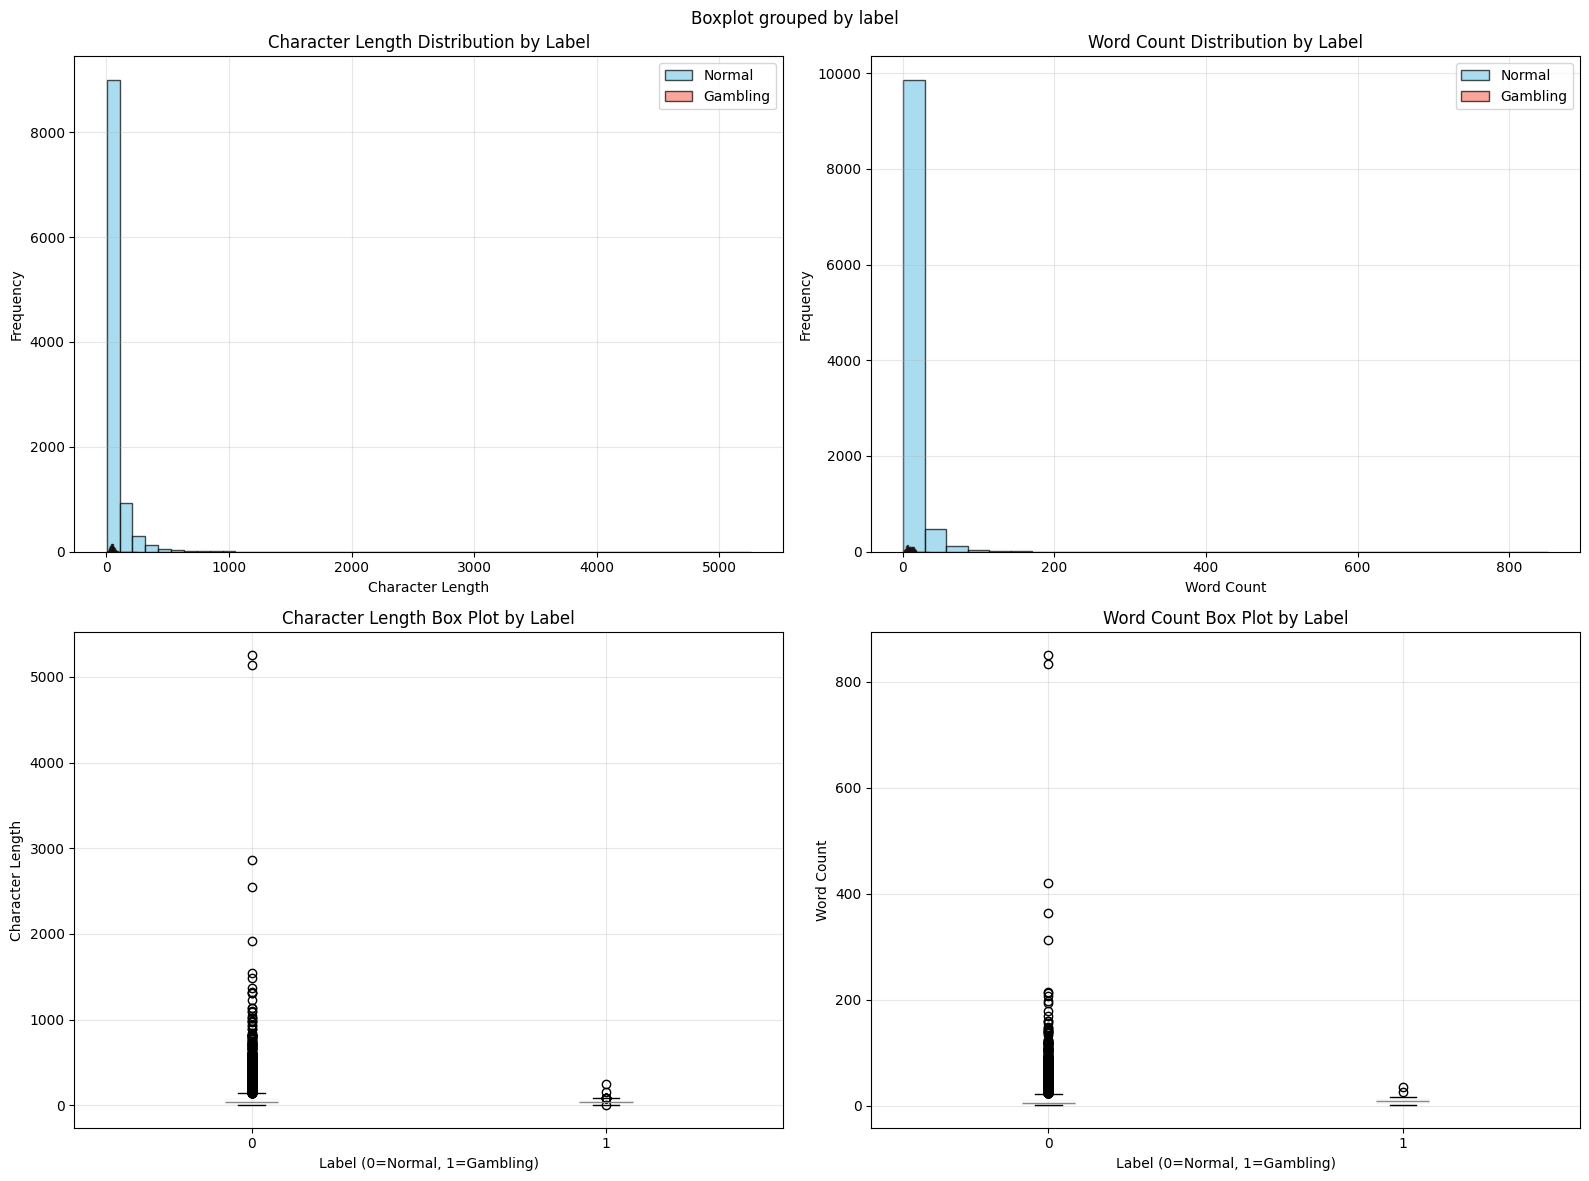

🧪 STATISTICAL SIGNIFICANCE TESTS
Character Length Difference Test (Mann-Whitney U):
  Statistic: 5076288.00
  P-value: 1.86e-19
  Result: Significant difference

Word Count Difference Test (Mann-Whitney U):
  Statistic: 4474906.00
  P-value: 2.84e-48
  Result: Significant difference

📏 EFFECT SIZES (Cohen's d):
  Character length: 0.173 (Small effect)
  Word count: 0.071 (Small effect)


☁️ GENERATING WORD CLOUDS


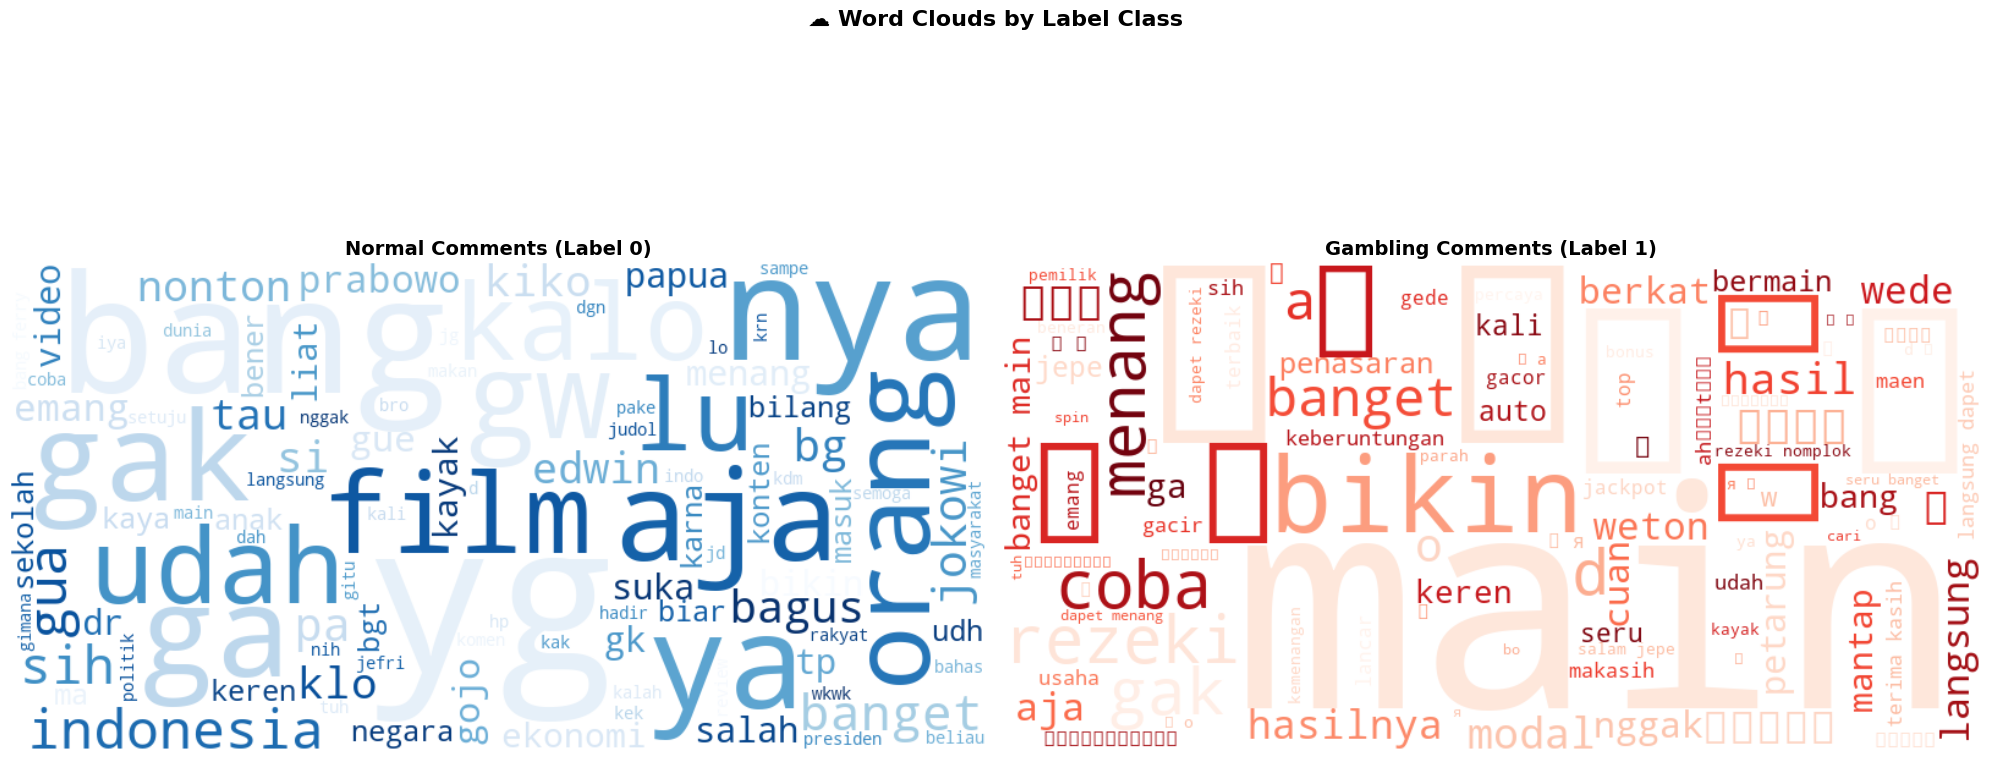

✅ Word clouds generated successfully!

🔍 CLEANING COMPARISON ANALYSIS
Sample gambling comments - Old vs New cleaning:
--------------------------------------------------
1. Original: '𝐃 𝐎 𝙍 𝘈 𝟽 7 emang gachor parah'
   Old method: '𝐃 𝐎 𝙍 𝘈 emang gachor parah'
   New method: '𝐃𝐎𝙍𝘈 emang gachor parah'
   Old word count: 7
   New word count: 4

2. Original: 'main d 𝐸 𝐖 𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan terima kasih 🍞'
   Old method: 'main d 𝐸 𝐖 𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan terima kasih'
   New method: 'main d 𝐸 𝐖𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan terima kasih'
   Old word count: 14
   New word count: 13

3. Original: 'makasih 𝐊𝗨𝗦𝗨𝗠𝗔𝗧𝟎𝗧𝟎uda ngasih 🔍 ✅'
   Old method: 'makasih 𝐊𝗨𝗦𝗨𝗠𝗔𝗧𝗧uda ngasih'
   New method: 'makasih 𝐊𝗨𝗦𝗨𝗠𝗔𝗧𝗧uda ngasih'
   Old word count: 3
   New word count: 3



🧪 TESTING IMPROVED STYLIZED TEXT HANDLING
Original vs Cleaned Examples:
----------------------------------------
1. Original: '𝐃 𝐎 𝙍 𝘈 𝟽 7 emang gachor parah'
   Cleaned:  '𝐃𝐎𝙍𝘈 emang gachor parah'
   Words:    ['𝐃𝐎𝙍𝘈', 'emang', 'gachor', 'parah']

2. Original: 'main d 𝐸 𝐖 𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan'
   Cleaned:  'main d 𝐸 𝐖𝐀 d 𝑂 𝑅 a bikin hariku menyenangkan'
   Words:    ['main', 'd', '𝐸', '𝐖𝐀', 'd', '𝑂', '𝑅', 'a', 'bikin', 'hariku', 'menyenangkan']

3. Original: 'coba aja 𝑲𝑰𝑵𝑮𝟑𝟐𝟖 mantap'
   Cleaned:  'coba aja 𝑲𝑰𝑵𝑮 mantap'
   Words:    ['coba', 'aja', '𝑲𝑰𝑵𝑮', 'mantap']

4. Original: '𝗠𝗜𝗬𝗔𝟴𝟴 kayak investasi roket'
   Cleaned:  '𝗠𝗜𝗬𝗔 kayak investasi roket'
   Words:    ['𝗠𝗜𝗬𝗔', 'kayak', 'investasi', 'roket']

🔤 TOP WORDS ANALYSIS


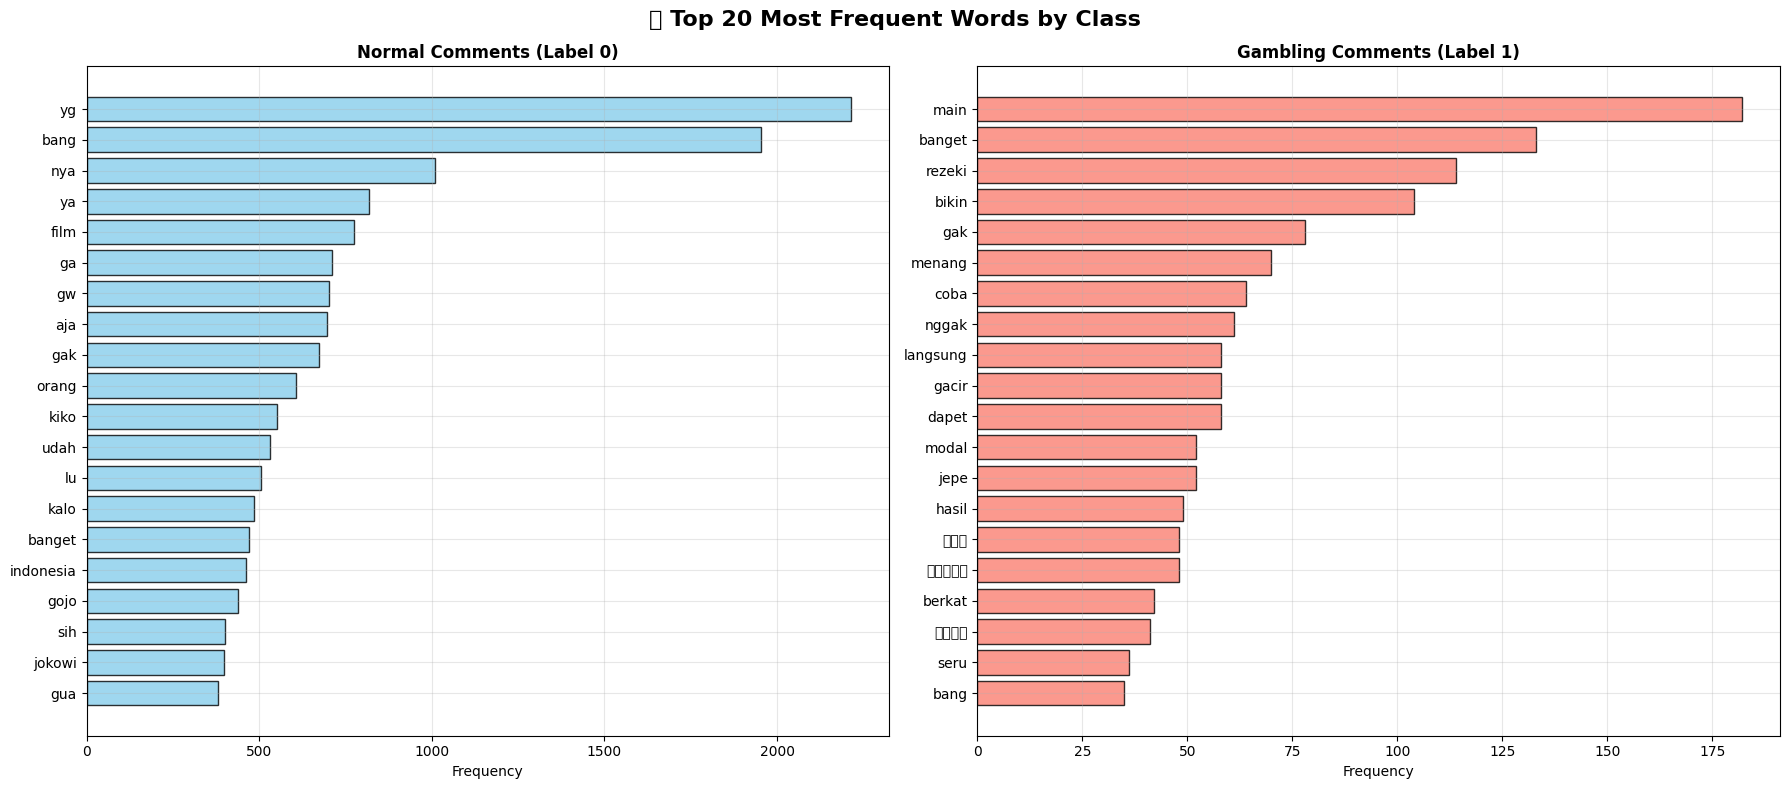

📝 TOP 20 WORDS - NORMAL COMMENTS:
 1. yg              (2,214 times)
 2. bang            (1,954 times)
 3. nya             (1,010 times)
 4. ya              (817 times)
 5. film            (775 times)
 6. ga              (710 times)
 7. gw              (701 times)
 8. aja             (696 times)
 9. gak             (672 times)
10. orang           (608 times)
11. kiko            (551 times)
12. udah            (531 times)
13. lu              (505 times)
14. kalo            (484 times)
15. banget          (471 times)
16. indonesia       (462 times)
17. gojo            (439 times)
18. sih             (400 times)
19. jokowi          (398 times)
20. gua             (380 times)

📝 TOP 20 WORDS - GAMBLING COMMENTS:
 1. main            (182 times)
 2. banget          (133 times)
 3. rezeki          (114 times)
 4. bikin           (104 times)
 5. gak             (78 times)
 6. menang          (70 times)
 7. coba            (64 times)
 8. nggak           (61 times)
 9. langsung        (58 times)


🔤 N-GRAM ANALYSIS
🔍 Extracting bigrams and trigrams...


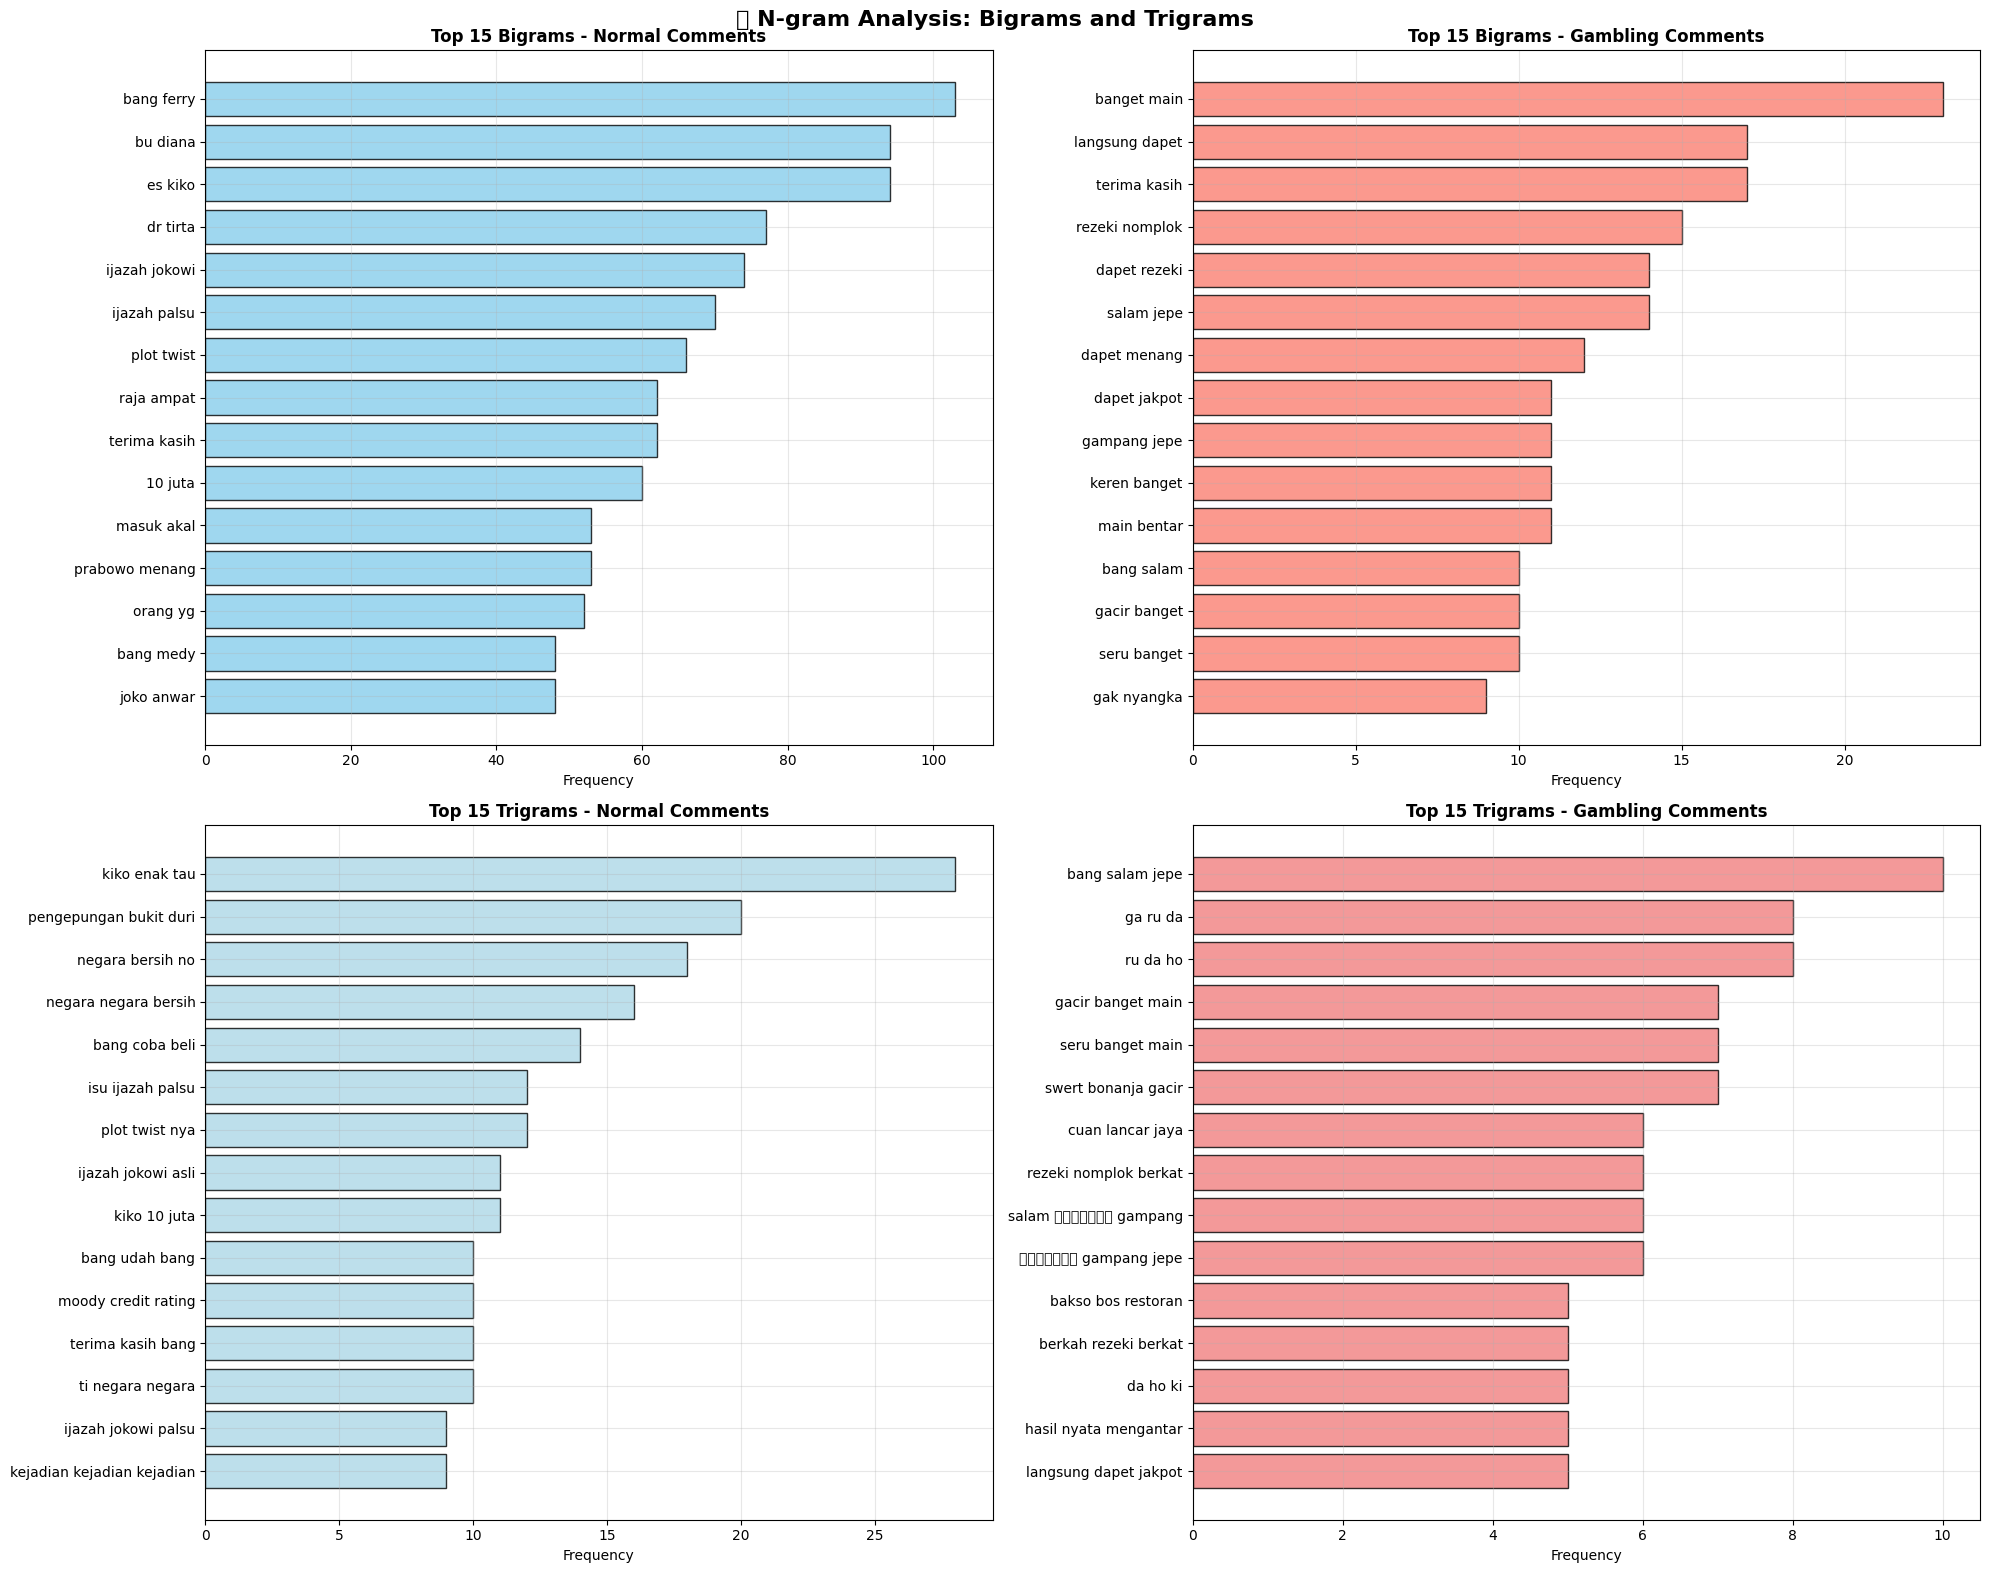

✅ N-gram analysis completed!


📋 DETAILED N-GRAM RESULTS
🔹 TOP 15 BIGRAMS - NORMAL COMMENTS:
 1. 'bang ferry' (103 times)
 2. 'bu diana' (94 times)
 3. 'es kiko' (94 times)
 4. 'dr tirta' (77 times)
 5. 'ijazah jokowi' (74 times)
 6. 'ijazah palsu' (70 times)
 7. 'plot twist' (66 times)
 8. 'raja ampat' (62 times)
 9. 'terima kasih' (62 times)
10. '10 juta' (60 times)
11. 'masuk akal' (53 times)
12. 'prabowo menang' (53 times)
13. 'orang yg' (52 times)
14. 'bang medy' (48 times)
15. 'joko anwar' (48 times)

🔸 TOP 15 BIGRAMS - GAMBLING COMMENTS:
 1. 'banget main' (23 times)
 2. 'langsung dapet' (17 times)
 3. 'terima kasih' (17 times)
 4. 'rezeki nomplok' (15 times)
 5. 'dapet rezeki' (14 times)
 6. 'salam jepe' (14 times)
 7. 'dapet menang' (12 times)
 8. 'dapet jakpot' (11 times)
 9. 'gampang jepe' (11 times)
10. 'keren banget' (11 times)
11. 'main bentar' (11 times)
12. 'bang salam' (10 times)
13. 'gacir banget' (10 times)
14. 'seru banget' (10 times)
15. 'gak nyangka' (9 times)

🔹 TOP 15 TRIGRAMS - NORMAL COMMENT

📚 VOCABULARY ANALYSIS
📊 VOCABULARY STATISTICS
------------------------------
Normal Comments:
  Total words: 107,260
  Unique words: 20,813
  Vocabulary richness: 0.1940

Gambling Comments:
  Total words: 9,498
  Unique words: 1,726
  Vocabulary richness: 0.1817

🔍 TF-IDF ANALYSIS


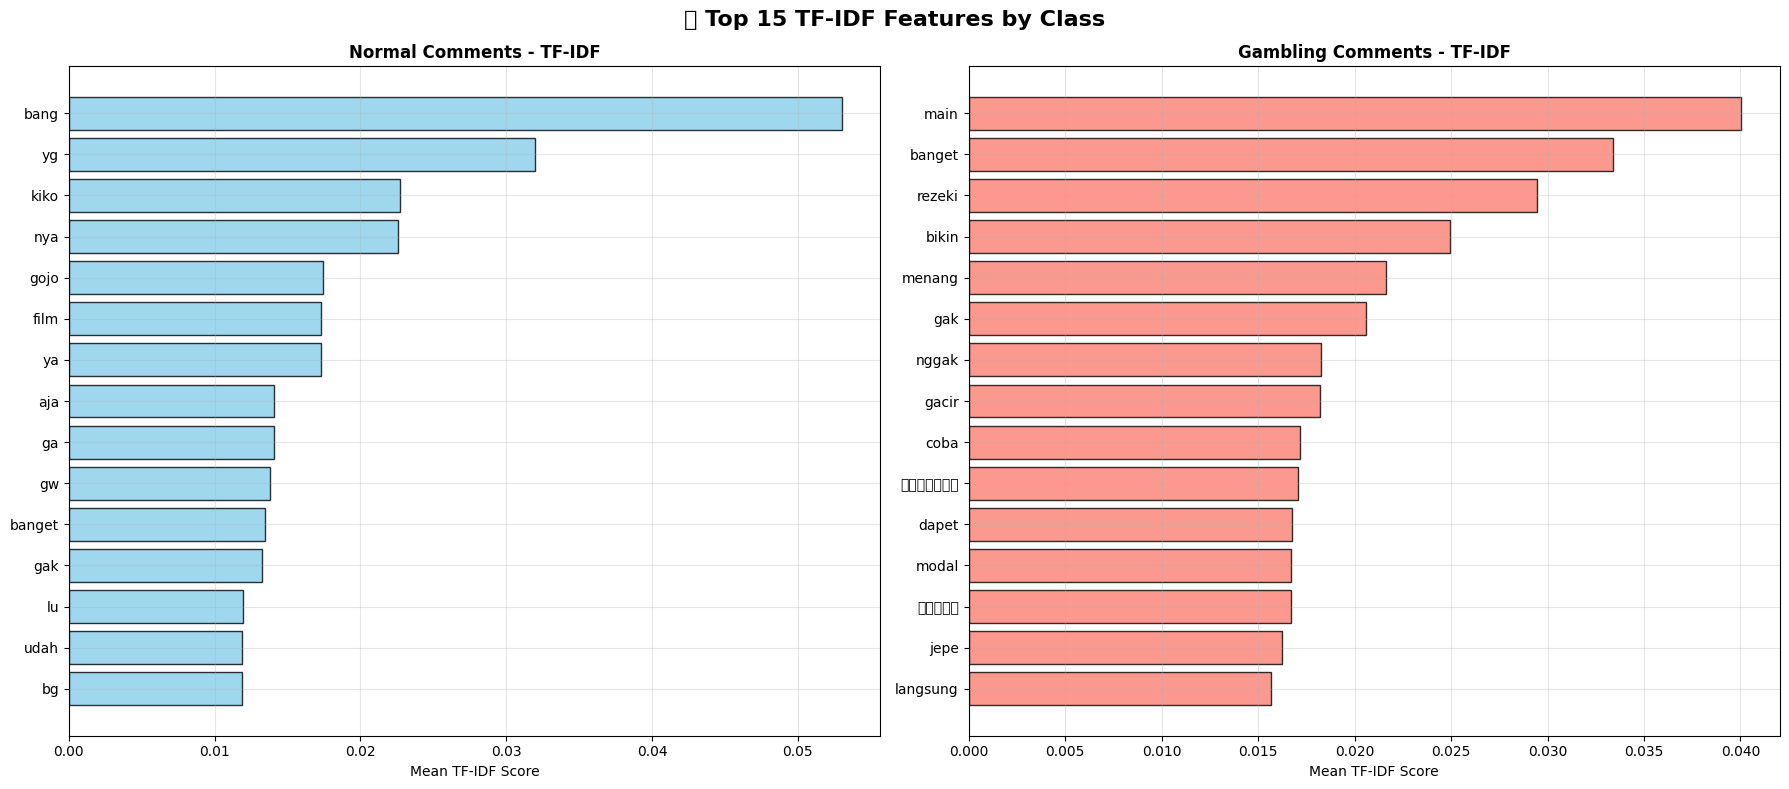

✅ Vocabulary and TF-IDF analysis completed!


In [48]:
# Vocabulary Analysis
print("📚 VOCABULARY ANALYSIS")
print("=" * 25)

# Calculate vocabulary statistics
def get_vocabulary_stats(texts):
    all_text = ' '.join(texts).lower()
    words = re.findall(r'\b\w+\b', all_text)
    unique_words = set(words)
    
    return {
        'total_words': len(words),
        'unique_words': len(unique_words),
        'vocabulary_richness': len(unique_words) / len(words)
    }

normal_vocab = get_vocabulary_stats(normal_comments)
gambling_vocab = get_vocabulary_stats(gambling_comments)

print("📊 VOCABULARY STATISTICS")
print("-" * 30)
print(f"Normal Comments:")
print(f"  Total words: {normal_vocab['total_words']:,}")
print(f"  Unique words: {normal_vocab['unique_words']:,}")
print(f"  Vocabulary richness: {normal_vocab['vocabulary_richness']:.4f}")

print(f"\nGambling Comments:")
print(f"  Total words: {gambling_vocab['total_words']:,}")
print(f"  Unique words: {gambling_vocab['unique_words']:,}")
print(f"  Vocabulary richness: {gambling_vocab['vocabulary_richness']:.4f}")

# TF-IDF Analysis
print("\n🔍 TF-IDF ANALYSIS")
print("=" * 20)

# Get top TF-IDF features for each class
def get_tfidf_features(texts, max_features=20):
    tfidf = TfidfVectorizer(max_features=1000, stop_words=None, ngram_range=(1, 1))
    X = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    
    # Calculate mean TF-IDF scores
    mean_scores = X.mean(axis=0).A1
    
    # Create feature-score pairs and sort
    feature_scores = list(zip(feature_names, mean_scores))
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    
    return feature_scores[:max_features]

normal_tfidf = get_tfidf_features(normal_comments, 15)
gambling_tfidf = get_tfidf_features(gambling_comments, 15)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('📚 Top 15 TF-IDF Features by Class', fontsize=16, fontweight='bold')

# Normal TF-IDF
if normal_tfidf:
    words, scores = zip(*normal_tfidf)
    axes[0].barh(words, scores, color='skyblue', alpha=0.8, edgecolor='black')
    axes[0].set_title('Normal Comments - TF-IDF', fontweight='bold')
    axes[0].set_xlabel('Mean TF-IDF Score')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3)

# Gambling TF-IDF
if gambling_tfidf:
    words, scores = zip(*gambling_tfidf)
    axes[1].barh(words, scores, color='salmon', alpha=0.8, edgecolor='black')
    axes[1].set_title('Gambling Comments - TF-IDF', fontweight='bold')
    axes[1].set_xlabel('Mean TF-IDF Score')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Vocabulary and TF-IDF analysis completed!")


🧹 DATA QUALITY ANALYSIS
🔍 DUPLICATE ANALYSIS
-------------------------
Total samples: 11,673
Duplicate comments (same text): 0 (0.00%)
Exact duplicates (text + label): 0 (0.00%)

📏 LENGTH ANALYSIS
--------------------
Empty comments: 0
Very short comments (≤3 chars): 172 (1.47%)
Short comments (≤10 chars): 1115 (9.55%)

🔤 SPECIAL CHARACTERS ANALYSIS
-----------------------------------
Character Usage Comparison:
               Normal Comments  Gambling Comments  Normal %  Gambling %
numbers                   2682                737     25.49       64.03
special_chars             3222                803     30.62       69.77
emojis                    2457                311     23.35       27.02
uppercase                    0                  0      0.00        0.00
urls                        23                  0      0.22        0.00
mentions                     0                  0      0.00        0.00
hashtags                     0                  0      0.00        0.00

🎨 STYLI

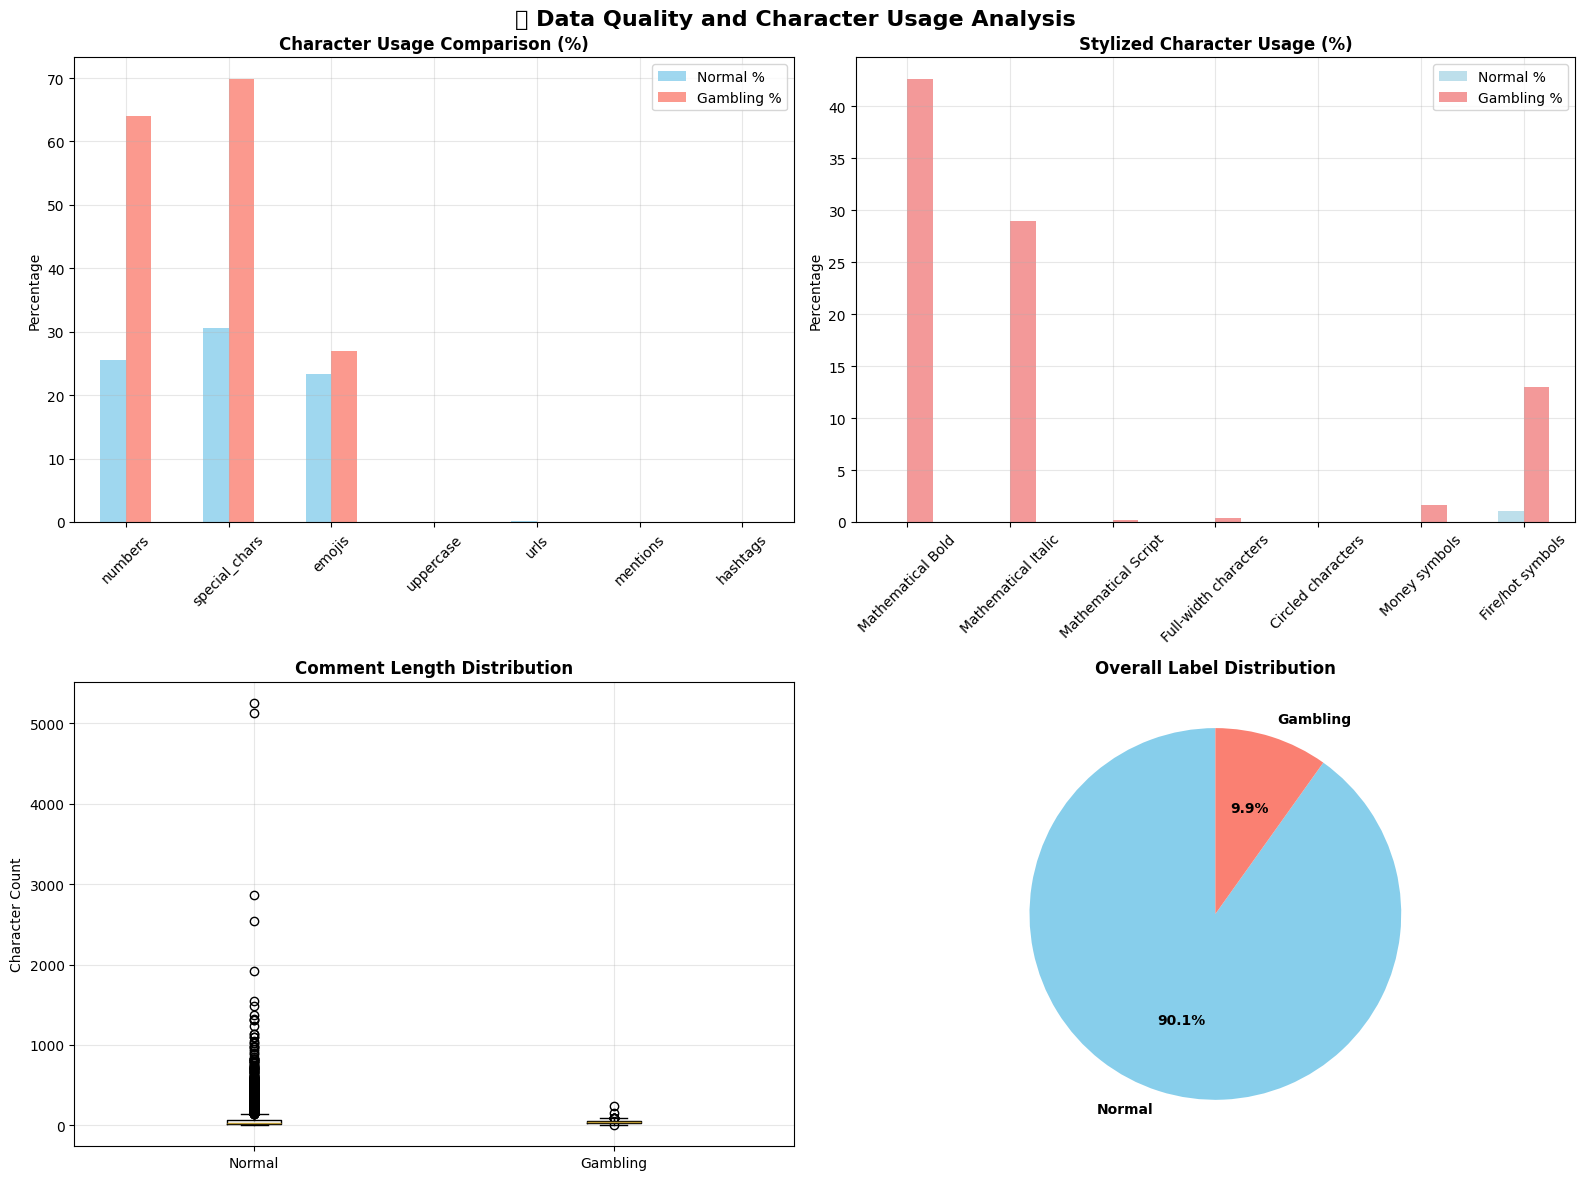


💡 PREPROCESSING RECOMMENDATIONS
Based on the analysis, consider the following preprocessing steps:

1. 🧹 Text Cleaning:
   - Remove or normalize stylized Unicode characters
   - Handle mathematical bold/italic characters
   - Consider emoji normalization/removal

2. 🔤 Character Normalization:
   - Convert full-width characters to standard ASCII
   - Normalize repeated characters (e.g., 'cooool' → 'cool')
   - Handle case sensitivity appropriately

3. 🗂️ Data Quality:
   - Review 172 very short comments
   - Consider minimum length thresholds

4. 🎯 Feature Engineering:
   - Extract stylized character features
   - Count special symbols (money, fire emojis)
   - Text length and word count features
   - N-gram features from distinctive patterns

✅ Data quality analysis completed!


🔍 EXPLORATORY DATA ANALYSIS SUMMARY
📊 DATASET OVERVIEW:
--------------------
• Total samples: 11,673
• Training samples: 8,171 (70.0%)
• Test samples: 2,335 (20.0%)
• Holdout samples: 1,167 (10.0%)

🏷️ LABEL DISTRIBUTION:
-------------------------
• Normal comments (0): 10,522 (90.1%)
• Gambling comments (1): 1,151 (9.9%)
• Class imbalance ratio: 9.1:1

📏 TEXT CHARACTERISTICS:
-------------------------
• Average length - Normal: 65.9 chars, Gambling: 44.8 chars
• Average words - Normal: 10.5 words, Gambling: 9.2 words
• Vocabulary richness - Normal: 0.194, Gambling: 0.182

🎨 SPECIAL CHARACTERISTICS:
------------------------------
• Stylized text usage: 42.6% in gambling vs 0.0% in normal
• Money symbols: 1.7% in gambling vs 0.0% in normal
• Emoji usage: 27.0% in gambling vs 23.4% in normal

🔤 TOP DISTINGUISHING WORDS:
-----------------------------------
Gambling-specific terms found:
• main, banget, rezeki, bikin, gak
• Many contain stylized characters and gambling-related terms

⚠️ DA

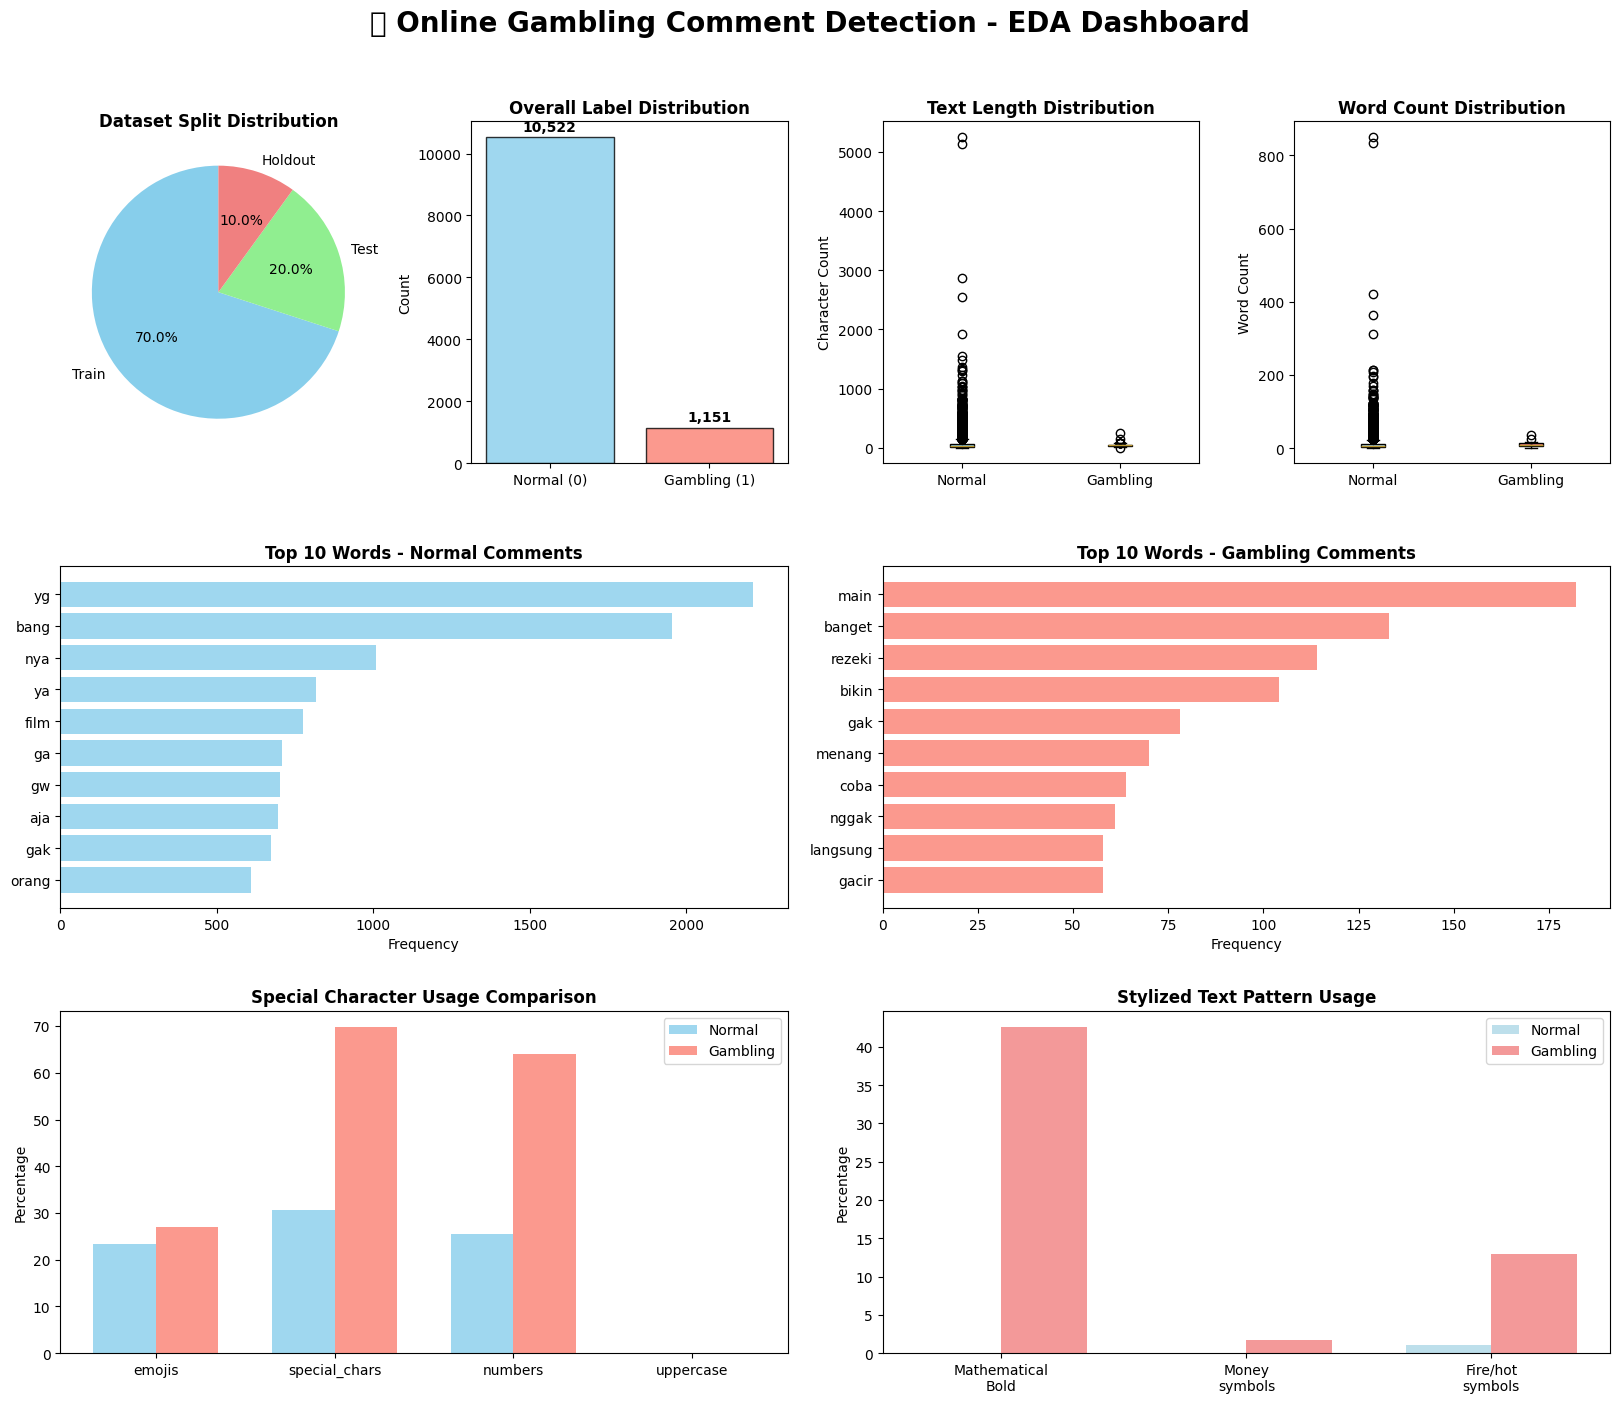

📊 Comprehensive EDA dashboard created!
🎯 All visualizations show clear distinguishing patterns between normal and gambling comments.
